# PyTorch workflow

The implementation and learning of PyTorch workflow

Follow freeCodeCamp.org, what will be covered: 
1. : "data (prepare data and load),
2. : "build a model",
3. : "train the model using prepared data, 
4. : "saving model checkpoint and load it up", 
5. : "combine what we learn together"

In [4]:
import torch
print(torch.cuda.is_available())

from torch import nn 
import matplotlib.pyplot as plt 

print(torch.__version__)

True
2.5.1+cu124


##  1. Data (prepare data and loading data)

This will consist of: 
* Excel spreadsheet
* Image
* Video - Images
* Audio
* Text for LLM

Machine can not read our data, it can only read 0 and 1 - numerical version of data, so we have to: 
1. Convert data into numerical version 
2. Build a model to learn some what of a patterns from those datas

Like any old school lession the first form of "learnable" thing come in with linear regression with 
`Y = aX + b`, we'll use this formualla to make a straight line base on our data. 

In [7]:
# first create some data
import torch
X = torch.arange(start = 0, end = 1, step = 0.02).unsqueeze(dim = 1) # add another dimension 
Y = 0.3 * X + 0.7 

print(X[:10])
print(Y[:10])

print(len(X), len(Y))

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])
tensor([[0.7000],
        [0.7060],
        [0.7120],
        [0.7180],
        [0.7240],
        [0.7300],
        [0.7360],
        [0.7420],
        [0.7480],
        [0.7540]])
50 50


### Splitting the data into train and test set (validate if we can). 
* Training set -> the model learns from this data - ~60-80%
* Validation set -> used to tune the model
* Test -> the model will get evaluated on this dataset to see what it learn and how well it perform 

In [10]:
# create train/test split 

train_split = int(0.8 * len(X))
print(train_split)

X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]

print(len(X_train))

40
40


In [21]:
def plot_predictions(train_data = X_train, 
					 train_labels = Y_train, 
					 test_data = X_test, 
					 test_labels = Y_test, 
					 predictions=None):
	plt.figure(figsize=(10,7))

	# Plot the training data 
	plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

	# Plot test data 
	plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

	if predictions is not None: 
		plt.scatter(test_data, predictions, c="r", s=4, label="Prediction")

	plt.legend(prop={"size": 14})

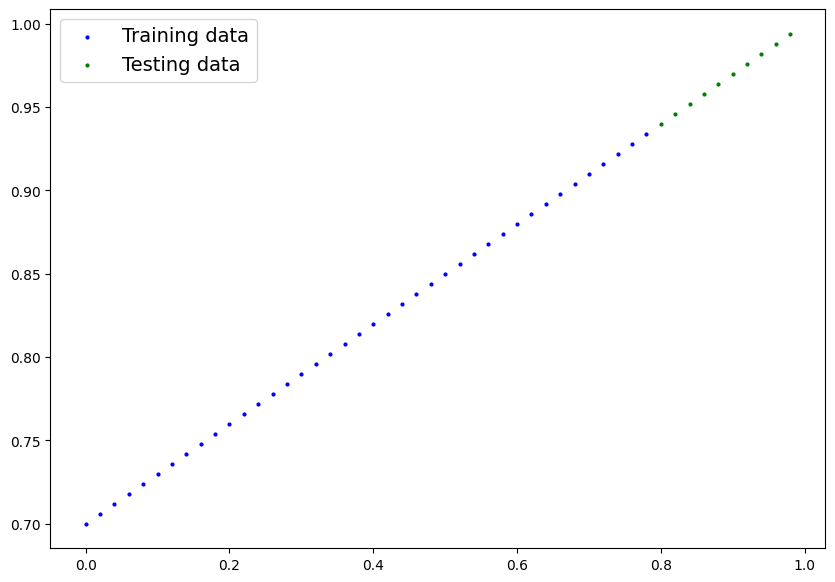

In [22]:
plot_predictions()